In [1]:
# Import necessary libraries
import os  # For interacting with the operating system
import sys  # For accessing system-specific parameters and functions
import torch  # Main PyTorch library for deep learning
import timm  # PyTorch library that provides pretrained models and model layers
import numpy as np  # Library for numerical operations on large, multi-dimensional arrays and matrices
import pandas as pd  # Library for data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Statistical data visualization
from PIL import Image  # Image processing library
from tqdm.notebook import tqdm  # Progress bar for Jupyter notebooks
from torchvision import transforms  # PyTorch image transformations
from torch.utils.data import Dataset, DataLoader  # For handling data loading and batching
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay  # Evaluation metrics
from timm.models.layers import trunc_normal_  # Initialization function for model layers
from timm import create_model  # For creating models from timm library
from functools import partial  # Utility for creating partial functions

# Add a parent directory to the system path to import the 'models_vit' module
sys.path.append(os.path.join('..'))
import models_vit  # Import a custom module for Vision Transformers

# Import custom modules
from util.misc import NativeScalerWithGradNormCount as NativeScaler  # Scaler for mixed-precision training
import util.misc as misc  # Import other miscellaneous utilities
from util.pos_embed import interpolate_pos_embed  # Function to handle positional embedding in Vision Transformers
import util.lr_decay as lrd  # Import learning rate decay functionality

# Re-import PyTorch to ensure all libraries are correctly imported (potential redundancy)
import torch
from torch.utils.data import DataLoader  # Re-import DataLoader for dataset batching


In [2]:
from IPython.display import display, HTML, Image as IPImage
import gdown

# 2) Load Model and Predict

## a) backbone model

In [3]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)
        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)
            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]
        return outcome

def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# Función para cargar el estado del modelo y otros componentes
def load_checkpoint(checkpoint_path, model):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Ajustar las claves del state_dict
    state_dict = checkpoint['model']
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace('fc_norm', 'norm')
        new_state_dict[new_key] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    
    epoch = checkpoint['epoch']
    
    return model, epoch

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## b) download model

### Instructions for Downloading Predictions
To ensure smooth operation of this Jupyter Notebook:
1. **Download automatically the file** using the next cell
2. **OR:** Download the file manually from the following Google Drive link and skip the next cell:
    1. Finetuning model Gastrovision:  [Download File](https://drive.google.com/uc?id=1tLlzCu1OQRC_bDEwBraz5S4GqBZvwVww) define num_classes=22.

In [4]:
WEIGHTS_URLS = {'checkpoint_GastroVision': "https://drive.google.com/uc?id=1tLlzCu1OQRC_bDEwBraz5S4GqBZvwVww" }
# Corresponding output file paths
output_paths = ['checkpoint-49.pth']

# Iterate through URLs and corresponding output paths
for key, output_file in zip(WEIGHTS_URLS.keys(), output_paths):
    if not os.path.exists(output_file):
        print(f"Downloading {output_file}...")
        gdown.download(url=WEIGHTS_URLS[key], output=output_file, quiet=False)
    else:
        print(f"{output_file} already exists!")


checkpoint-49.pth already exists!


## c) load model

In [5]:
# Path to the saved checkpoint file
checkpoint_path = "checkpoint-49.pth"

# Define the model and other components
model = vit_large_patch16(num_classes=22, global_pool=True)  # Instantiate a Vision Transformer model with 22 classes for GastroVision categoeries
model.to(device)  # Move the model to the specified device (e.g., GPU or CPU)
loss_scaler = NativeScaler()  # Set up a scaler for mixed-precision training to manage gradient scaling

# Load the checkpoint
model, start_epoch = load_checkpoint(checkpoint_path, model)  # Load model weights and resume training from the checkpoint

# Set up the optimizer consistently for all model parameters
param_groups = lrd.param_groups_lrd(  # Create parameter groups with layer-wise learning rate decay
    model, 0.05,  # Set the base learning rate multiplier
    no_weight_decay_list=model.no_weight_decay(),  # Specify parameters to exclude from weight decay
    layer_decay=0.75  # Apply a decay factor across model layers
)
optimizer = torch.optim.AdamW(param_groups, lr=1e-3)  # Use the AdamW optimizer with a base learning rate

# Get predictions
model.eval()

# Confirm the model has been loaded correctly
print(f'Load model {checkpoint_path}, epoch {start_epoch}')  # Print checkpoint path and the starting epoch

Load model checkpoint-49.pth, epoch 49


## e) Predict label

In [6]:
WEIGHTS_URLS = {'image_GastroVision': "https://drive.google.com/uc?id=1dPkxhiADHiagrLJnVN3uwgfIkOS2dc3R" }

# Corresponding output file paths
output_paths = ['000c10f1-372c-4ed0-9e05-a00d56d701b0.png']

# Iterate through URLs and corresponding output paths
for key, output_file in zip(WEIGHTS_URLS.keys(), output_paths):
    if not os.path.exists(output_file):
        print(f"Downloading {output_file}...")
        gdown.download(url=WEIGHTS_URLS[key], output=output_file, quiet=False)
    else:
        print(f"{output_file} already exists!")


000c10f1-372c-4ed0-9e05-a00d56d701b0.png already exists!


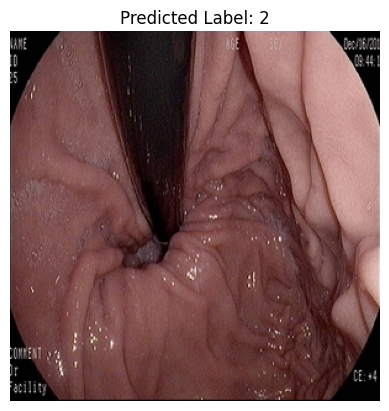

In [7]:
img = Image.open("000c10f1-372c-4ed0-9e05-a00d56d701b0.png").convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image; adjust dimensions as needed
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize([0.5575, 0.3902, 0.3250], [0.2522, 0.1944, 0.1745])  # Normalize using specified mean and std
])
imgt = transform(img)  # Apply the transformation pipeline to the image
imgt = imgt.unsqueeze(0).to(device)  # Add batch dimension and move to the device

outputs = model(imgt)  # Forward pass through the model
_, preds = torch.max(outputs, 1)  # Get the predicted class

# If needed, convert the predictions to numpy format for further processing
preds = preds.cpu().numpy()

plt.imshow(img)  # Rearrange dimensions for display and move to CPU if on a GPU
plt.title(f"Predicted Label: {preds[0]}")  # Format title as a single string
plt.axis("off")  # Optionally turn off axis for better viewing
plt.show()
